In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from collections import Counter

import pandas as pd
from metrics import metrics, metrics_balanced
import numpy as np

In [2]:
RS = 42

In [3]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("present", axis=1)  #.dropna()
data.head()

,e_Vmag,Bmag,e_Bmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,fuv_mag,nuv_mag,err,type,min_mag,max_mag
0,0.033,11.080,0.024,13.351,3.579,12.599,3.330,10.066,0.031,22.017,15.786,4.888841,NaN,NaN,NaN
1,0.053,14.767,0.040,14.272,0.209,15.754,4.109,13.373,0.773,23.920,19.509,4.186825,NaN,NaN,NaN
2,0.046,12.909,0.045,12.494,0.197,14.430,3.722,11.920,0.520,23.090,16.583,3.763859,NaN,NaN,NaN
3,0.041,14.127,0.041,13.766,0.181,15.375,3.672,13.049,0.672,24.091,17.881,3.737819,NaN,NaN,NaN
4,0.077,14.042,0.048,13.634,0.208,15.422,3.632,13.227,0.000,22.714,17.651,3.639082,RS,13.29,13.41


In [4]:
eruptive_keywords = [
    "FU", "GCAS", "IN", "RCB", "SDOR", "UV", "WR", "RS", "TTAU", "FLARE"
]

pulsating_keywords = [
    "CEP", "CW", "DCEP", "DSCT", "M", "MIRA", "RR", "RV", "SR", 
    "SRA", "SRB", "SRC", "SRD", "BCEP", "ZZ", "ACYG", "SXPHE", "PVTEL", "BLBOO"
]

rotating_keywords = [
    "ROT", "BY", "ELL", "ACV", "FKCOM", "SXARI", "PSR"
]

eclipsing_keywords = [
    "E", "EA", "EB", "EW", "EC", "EL", "ALGOL", "BLYR", "WUMA"
]

In [5]:
def classify_type(vtype: str) -> str:
    """
    Возвращает укрупнённый класс переменной звезды
    в зависимости от содержимого строки vtype.
    """

    if pd.isna(vtype) or not isinstance(vtype, str) or vtype.strip() == "":
        return "UNKNOWN"  # Или "UNKNOWN", если хотите отдельно отметить NaN и пустые

    # Приведём к верхнему регистру для надёжного поиска подстрок
    t = vtype.upper()

    # --- 1) Затменные (Eclipsing Binaries) ---
    # Ищем любые подтипы: EA, EB, EW, EC, ELL, E/RS и т.д.
    # Включим также "E|" (встречается в комбинированных типах) и просто "E" (бывает)
    ecl_markers = ["EA", "EB", "EW", "EC", "ELL", "E/RS", "E|", "E "]
    if any(m in t for m in ecl_markers):
        return "ECLIPSING"

    # --- 2) Цефеиды и родственные (DCEP, CW, RV Tauri, ACEP) ---
    cep_markers = ["DCEP", "CW-FU", "CW", "CWA", "CWB", "RVA", "RV", "ACEP", "CEP"]
    # Примечание: "RV" может пересекаться с "RVC", "ROT" и пр.,
    # поэтому в реальном коде можно уточнять условия, но здесь — упрощённо.
    if any(m in t for m in cep_markers):
        return "CEPHEIDS"

    # --- 3) RR Лиры (RRAB, RRC, RRD, RR...) ---
    rr_markers = ["RRAB", "RRC", "RRD", "RR"]
    if any(m in t for m in rr_markers):
        return "RR_LYRAE"

    # --- 4) Короткопериодические пульсаторы: DSCT, SXPHE, GDOR, roAp ---
    short_puls = ["DSCT", "HADS", "SXPHE", "GDOR", "ROAP", "ROAM"]
    if any(m in t for m in short_puls):
        return "DELTA_SCUTI_ETC"

    # --- 5) Долгопериодические и полуправильные (M, SR, L) ---
    # Mira (M), SR, SRA, SRB, SRC, SRD, L, LB, LC, LPV
    lpv_markers = [" M ", "MIRA", "SR", "SRA", "SRB", "SRC", "SRD", "L ", "LB", "LC", "LPV"]
    # Для "M" можно проверять отдельно, чтобы не совпадало с "MISC", поэтому " M " с пробелами,
    # но тут для упрощения — любой "M". В реальном коде нужна аккуратность или RegEx.
    if any(m in t for m in lpv_markers):
        return "LONG_PERIOD"

    # --- 6) Ротационные переменные (BY, RS, ACV, SPB, ROT, GCAS) ---
    rot_markers = ["BY", "RS", "ACV", "SPB", "ROT", "GCAS"]
    if any(m in t for m in rot_markers):
        return "ROTATIONAL"

    # --- 7) Эруптивные/молодые звёзды (T Tauri, EXOR, UXOR, INS...) ---
    yso_markers = ["TTS", "EXOR", "UXOR", "INS", "IN", "INST", "CST"]  
    # "CST" иногда "constant?", но бывает и у молодых/неясных
    if any(m in t for m in yso_markers):
        return "YSO/ERUPTIVE"

    # --- Катаклизмические (UG, NL, AM, ZAND, IB, IS, ... ) ---
    cataclysmic_markers = ["UG", "NL", "AM", "ZAND", "IB", "ISB"]  # и др.
    if any(m in t for m in cataclysmic_markers):
        return "CATACLYSMIC"

    # --- 9) Горячие эмиссионные/WR/Be/симбиотические (WR, BE, FSCMa...) ---
    em_markers = ["WR", "BE", "FSCMA"]
    if any(m in t for m in em_markers):
        return "EMISSION_WR"

    # Если ничего не подошло, отправляем в "MISC" или "HYBRID"
    return "UNKNOWN"


# Теперь создаём новую колонку:
data["class"] = data["type"].apply(classify_type)
data.drop("type", axis=1, inplace=True)

# убрать "YSO/ERUPTIVE" и "EMISSION_WR"
data = data[(data['class'] != 'YSO/ERUPTIVE') & (data['class'] != 'EMISSION_WR')]

classes = data["class"].unique()
classes

array(['UNKNOWN', 'ROTATIONAL', 'ECLIPSING', 'DELTA_SCUTI_ETC',
       'CATACLYSMIC', 'RR_LYRAE', 'LONG_PERIOD', 'CEPHEIDS'], dtype=object)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data.drop("class", axis=1), data["class"], random_state=RS, train_size=0.8)
display(X_train.head())
display(Y_train.head())

,e_Vmag,Bmag,e_Bmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,fuv_mag,nuv_mag,err,min_mag,max_mag
861,0.030,12.862,0.075,12.814,0.813,12.144,0.079,12.103,0.167,23.381,16.735,0.837630,8.33,0.95
57090,0.021,13.062,0.026,12.774,0.021,12.452,0.038,12.384,0.039,22.429,16.166,0.067253,14.43,14.46
41920,0.025,15.552,0.035,15.192,0.064,14.840,0.060,14.717,0.034,23.813,19.516,0.103450,13.10,0.34
14946,0.032,15.913,0.096,15.573,0.067,15.033,0.020,14.898,0.155,23.372,20.399,0.197874,13.43,0.18
7503,0.057,17.109,0.139,16.633,0.101,15.971,0.068,15.652,0.207,23.181,22.673,0.283274,14.09,14.46


861      UNKNOWN
57090    UNKNOWN
41920    UNKNOWN
14946    UNKNOWN
7503     UNKNOWN
Name: class, dtype: object

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.36      0.84      0.50       229
      ECLIPSING       0.23      0.74      0.35        53
    LONG_PERIOD       0.09      1.00      0.17         1
     ROTATIONAL       0.26      0.88      0.40        96
       RR_LYRAE       0.61      0.79      0.69        75
        UNKNOWN       1.00      0.94      0.97     12544

       accuracy                           0.94     12998
      macro avg       0.32      0.65      0.38     12998
   weighted avg       0.97      0.94      0.95     12998



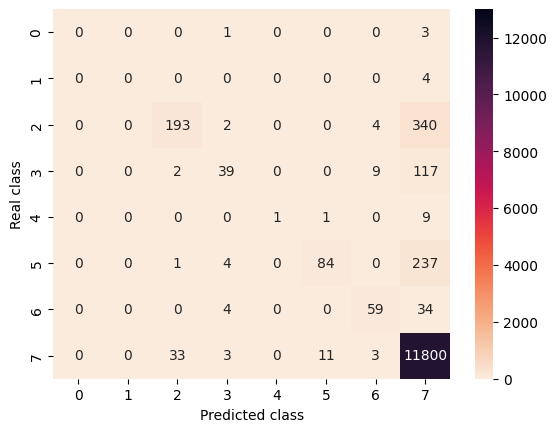

In [7]:
clf = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=42)
clf.fit(X_train, Y_train)

pred = clf.predict(X_test)
metrics(pred, Y_test, output=True, to_return=False)

                 precision    recall  f1-score   support

    CATACLYSMIC       0.80      1.00      0.89         4
       CEPHEIDS       0.85      1.00      0.92        11
DELTA_SCUTI_ETC       0.67      0.96      0.79      1415
      ECLIPSING       0.73      1.00      0.84       537
    LONG_PERIOD       0.94      1.00      0.97        32
     ROTATIONAL       0.83      1.00      0.91      1144
       RR_LYRAE       0.95      1.00      0.98       371
        UNKNOWN       1.00      0.98      0.99     48476

       accuracy                           0.98     51990
      macro avg       0.85      0.99      0.91     51990
   weighted avg       0.98      0.98      0.98     51990



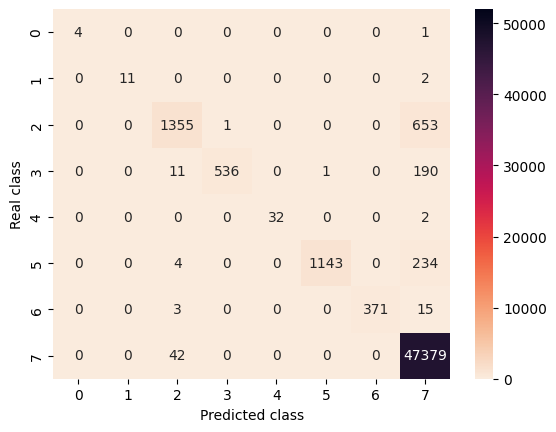

In [8]:
pred = clf.predict(X_train)
metrics(pred, Y_train, output=True, to_return=False)

Судя по тесту на **тренировочных** данных происходит переобучение. По крайней мере, если не ограничивать высоту деревьев точно.

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.36      0.98      0.53       196
      ECLIPSING       0.23      0.78      0.36        50
    LONG_PERIOD       0.09      1.00      0.17         1
     ROTATIONAL       0.26      0.99      0.41        85
       RR_LYRAE       0.61      0.82      0.70        72
        UNKNOWN       0.00      0.00      0.00       744

       accuracy                           0.33      1148
      macro avg       0.19      0.57      0.27      1148
   weighted avg       0.13      0.33      0.18      1148



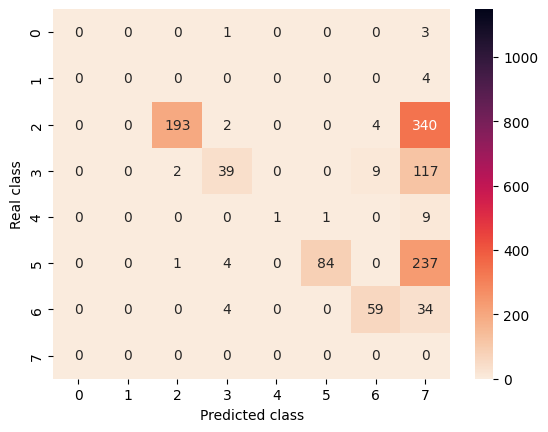

In [9]:
def drop_unknown(x, y):
  df = pd.concat([x, y], axis=1)
  df = df[df["class"] != "UNKNOWN"]
  return df

# уберем из теста "UNKNOWN", чтобы не засорять heatmap
df = drop_unknown(X_test, Y_test)
X_test_1 = df.iloc[:, :-1]
Y_test_1 = df["class"]
pred = clf.predict(X_test_1)
metrics(pred, Y_test_1, output=True, to_return=False)

Классификатор почти что случайный, в отличие от тренировочного датасета, либо примеры неудачные, либо происходит переобучение.

## Мультиклассификация только переменных звезд

In [10]:
data_var = data[data['class'] != "UNKNOWN"]
data_var.head()

,e_Vmag,Bmag,e_Bmag,gpmag,e_gpmag,rpmag,e_rpmag,ipmag,e_ipmag,fuv_mag,nuv_mag,err,min_mag,max_mag,class
4,0.077,14.042,0.048,13.634,0.208,15.422,3.632,13.227,0.000,22.714,17.651,3.639082,13.290,13.41,ROTATIONAL
12,2.511,10.404,0.164,10.150,0.154,9.764,0.207,9.667,0.205,18.929,14.765,2.537835,9.700,0.54,ECLIPSING
27,0.030,11.756,0.022,11.565,0.048,11.292,0.044,12.254,2.256,19.048,14.973,2.257246,11.270,11.34,DELTA_SCUTI_ETC
41,0.930,13.216,1.055,13.308,0.977,13.369,0.863,13.291,0.781,12.301,12.639,2.070552,10.500,16.30,CATACLYSMIC
51,0.807,15.295,1.049,15.069,0.972,14.962,0.765,15.012,0.375,18.330,17.027,1.849942,15.178,1.12,RR_LYRAE


                 precision    recall  f1-score   support

    CATACLYSMIC       1.00      1.00      1.00         8
       CEPHEIDS       1.00      1.00      1.00        11
DELTA_SCUTI_ETC       1.00      1.00      1.00      2045
      ECLIPSING       1.00      1.00      1.00       730
    LONG_PERIOD       1.00      1.00      1.00        31
     ROTATIONAL       1.00      1.00      1.00      1354
       RR_LYRAE       1.00      1.00      1.00       394

       accuracy                           1.00      4573
      macro avg       1.00      1.00      1.00      4573
   weighted avg       1.00      1.00      1.00      4573



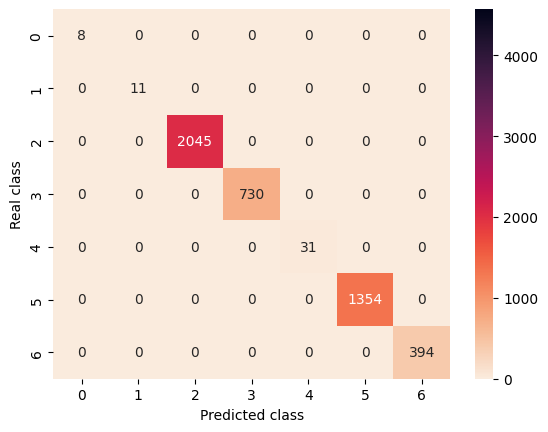

In [11]:
X_train_var, X_test_var, Y_train_var, Y_test_var = train_test_split(
    data_var.drop("class", axis=1), data_var["class"], random_state=RS, train_size=0.8)

clf = RandomForestClassifier(n_estimators=100, max_depth=24, random_state=42)
clf.fit(X_train_var, Y_train_var)

pred = clf.predict(X_train_var)
metrics(pred, Y_train_var, output=True, to_return=False)

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.96      0.89      0.93       543
      ECLIPSING       0.67      0.73      0.70       161
    LONG_PERIOD       0.43      1.00      0.60         6
     ROTATIONAL       0.90      0.90      0.90       355
       RR_LYRAE       0.74      0.86      0.80        79

       accuracy                           0.87      1144
      macro avg       0.53      0.63      0.56      1144
   weighted avg       0.88      0.87      0.87      1144



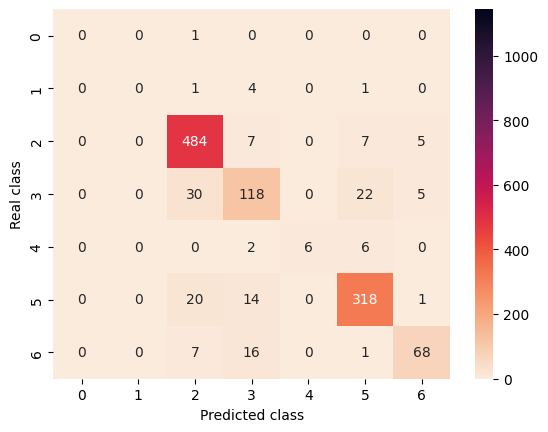

In [12]:
pred = clf.predict(X_test_var)
metrics(pred, Y_test_var, output=True, to_return=False)

Подберем наиболее оптимальную высоту деревьев через GridSearch

In [13]:
params = {
  "max_depth": [16, 24, 32]
}

gs = GridSearchCV(RandomForestClassifier(), params)
gs.fit(X_train_var, Y_train_var)
clf_multi = gs.best_estimator_
gs.best_estimator_

RandomForestClassifier(max_depth=24)

                 precision    recall  f1-score   support

    CATACLYSMIC       0.00      0.00      0.00         0
       CEPHEIDS       0.00      0.00      0.00         0
DELTA_SCUTI_ETC       0.96      0.89      0.93       543
      ECLIPSING       0.67      0.73      0.70       161
    LONG_PERIOD       0.43      1.00      0.60         6
     ROTATIONAL       0.90      0.90      0.90       355
       RR_LYRAE       0.74      0.86      0.80        79

       accuracy                           0.87      1144
      macro avg       0.53      0.63      0.56      1144
   weighted avg       0.88      0.87      0.87      1144



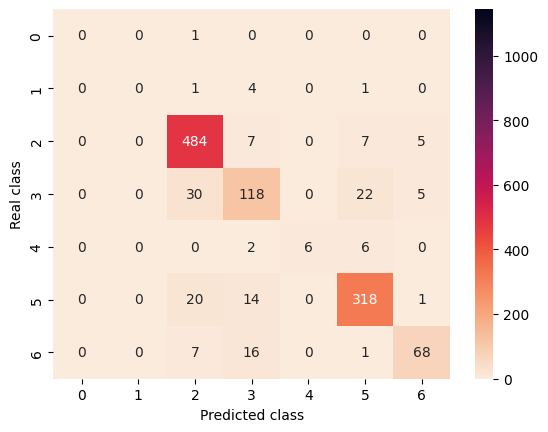

In [14]:
pred = clf.predict(X_test_var)
metrics(pred, Y_test_var, output=True, to_return=False)

Определим вначале тип звезды, а потом, если она переменная, и ее класс через мультиклассификатор

In [15]:
data_single = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()
X_single, _, Y_single, _ = train_test_split(data_single.drop("present", axis=1), data_single["present"], random_state=RS, train_size=0.8)
N = Y_single[Y_single == 1].size
data_single = pd.concat([data_single[data_single.present == 0].sample(N * 3),
                         data_single[data_single.present == 1].sample(N)])
X, Y = data_single.drop("present", axis=1), data_single["present"]
clf_single = RandomForestClassifier(max_depth=32, n_estimators=300, n_jobs=-1)
clf_single.fit(X, Y)

RandomForestClassifier(max_depth=32, n_estimators=300, n_jobs=-1)

                 precision    recall  f1-score   support

    CATACLYSMIC       1.00      1.00      1.00         4
       CEPHEIDS       0.50      1.00      0.67         2
DELTA_SCUTI_ETC       0.96      0.65      0.77       799
      ECLIPSING       0.89      0.72      0.80       206
    LONG_PERIOD       0.73      0.42      0.53        19
     ROTATIONAL       0.92      0.61      0.73       495
       RR_LYRAE       0.94      0.87      0.90       105
        UNKNOWN       0.96      1.00      0.98     11368

       accuracy                           0.95     12998
      macro avg       0.86      0.78      0.80     12998
   weighted avg       0.95      0.95      0.95     12998



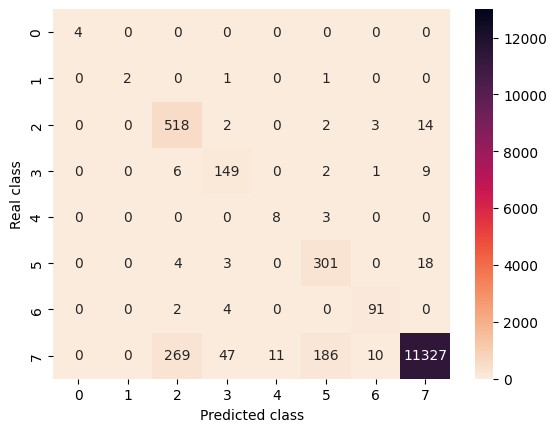

In [16]:
pred_all = clf_single.predict(X_test)

# отдельно предскажем переменные звезды
pred_var = clf.predict(X_test[pred_all == 1])

pred_res = []

j: int = 0
for i in pred_all:
  if i == 0:
    pred_res.append("UNKNOWN")
  else:
    pred_res.append(pred_var[j])
    j += 1

metrics(np.array(pred_res), Y_test, to_return=False)

                 precision    recall  f1-score   support

    CATACLYSMIC       1.00      1.00      1.00         4
       CEPHEIDS       0.50      1.00      0.67         2
DELTA_SCUTI_ETC       0.96      0.65      0.77       799
      ECLIPSING       0.89      0.72      0.80       206
    LONG_PERIOD       0.73      0.42      0.53        19
     ROTATIONAL       0.92      0.61      0.73       495
       RR_LYRAE       0.94      0.87      0.90       105
        UNKNOWN       0.96      1.00      0.98     11368

       accuracy                           0.95     12998
      macro avg       0.86      0.78      0.80     12998
   weighted avg       0.95      0.95      0.95     12998



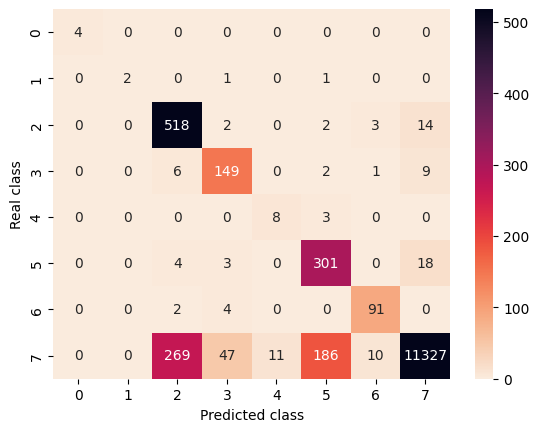

In [17]:
metrics_balanced(np.array(pred_res), Y_test, to_return=False)

## SMOTE

In [18]:
print("Original distibution")

for i in classes:
  print(i, data[data["class"] == i].size)

Original distibution
UNKNOWN 889065
ROTATIONAL 25605
ECLIPSING 13575
DELTA_SCUTI_ETC 38220
CATACLYSMIC 135
RR_LYRAE 7290
LONG_PERIOD 675
CEPHEIDS 255


In [19]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_var, Y_train_var)

print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({'ECLIPSING': 2045, 'DELTA_SCUTI_ETC': 2045, 'LONG_PERIOD': 2045, 'RR_LYRAE': 2045, 'ROTATIONAL': 2045, 'CATACLYSMIC': 2045, 'CEPHEIDS': 2045})
